In [1]:
__author__ = 'Erwin Chen'
# interact with plot
# %matplotlib nbagg
# simply show plot
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import numpy as np
import scipy.stats as stats
import scipy.cluster.hierarchy as h
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
import pickle

In [2]:
# load data from fits file
hdulist = fits.open('apogee-rc-DR12.fits')
hdulist.info()
tbdata = hdulist[1].data
# APOGEE ID for stars
apogee_ID = tbdata.field('APOGEE_ID')
# Galactic Longitude
l = tbdata.field('GLON')
# Galactic Latitude 
b = tbdata.field('GLAT')
# Right Ascension(J2000)
RA = tbdata.field('RA')
# Declination(J2000)
DEC = tbdata.field('DEC')
# Heliocentric radial velocity
RV = tbdata.field('VHELIO_AVG')
# Proper motion RA
PMRA = tbdata.field('PMRA')
# Proper motion DEC
PMDEC = tbdata.field('PMDEC')
# distance 
d = tbdata.field('RC_DIST')

Filename: apogee-rc-DR12.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       6   ()              
1                BinTableHDU    324   19937R x 157C   [45A, 44A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, 116A, J, I, E, J, 129A, J, 59A, E, E, E, E, 2E, 2E, 2E, I, 7E, 7E, 49E, 49E, 15E, 15E, 15E, 15E, E, E, E, E, E, E, E, E, E, 2A, J, 153A, 7J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 15E, 15J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, 17A, I, I, 737A, 665A, 50J, 50J, D, D, D, D, D, J, D, D, D, D, D, J, D, D, D, D, D, J, D, D, D, D, D, D, D, J, D, D, D]   


In [15]:
import galpy.util.bovy_coords as coords

# calculate space velocity for every star
C = np.where((PMRA > -9999)*(PMDEC > -9999))[0]
v_x = []
v_y = []
v_z = []
for n in range(len(C)):
    pm = coords.pmrapmdec_to_pmllpmbb(PMRA[C[n]], PMDEC[C[n]], RA[C[n]], DEC[C[n]], 
                                          degree=True, epoch=2000.)
    v_xyz = coords.vrpmllpmbb_to_vxvyvz(RV[C[n]], pm[0], pm[1], l[C[n]], b[C[n]], d[C[n]], 
                                           XYZ=False, degree=True)
    v_x.append(v_xyz[0])
    v_y.append(v_xyz[1])
    v_z.append(v_xyz[2])

In [23]:
data = [v_x, v_y]
data = np.array(data).T
db = DBSCAN().fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
labels.max()


31

(12834,)


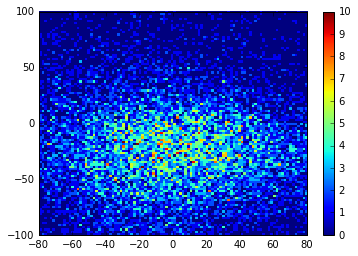

In [42]:
v_x = np.array(v_x)
v_y = np.array(v_y)
low_v = np.where((np.abs(v_x) < 80) * ((np.abs(v_y) < 100)))[0]
print low_v.shape
plt.hist2d(v_x[low_v], v_y[low_v], bins=100)
plt.colorbar()
plt.show()

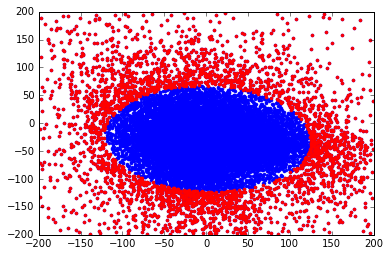

In [51]:
from sklearn.covariance import empirical_covariance, MinCovDet
robust_cov = MinCovDet().fit(data)
mahal_robust_cov = robust_cov.mahalanobis(data)
low_v = np.where((np.abs(v_x) < 200) * ((np.abs(v_y) < 200)))[0]
a = np.where(mahal_robust_cov > 5)[0]
a = np.intersect1d(low_v,a)
plt.plot(v_x[low_v], v_y[low_v], "b.")
plt.plot(v_x[a], v_y[a], "r.")
plt.show()

[ 89  90  94  95  96  98 100 105 107] [91 80 99 98 92 95 87 83 96]
[[ 89  91]
 [ 90  80]
 [ 94  99]
 [ 95  98]
 [ 96  92]
 [ 98  95]
 [100  87]
 [105  83]
 [107  96]]


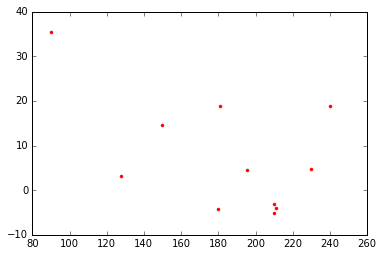

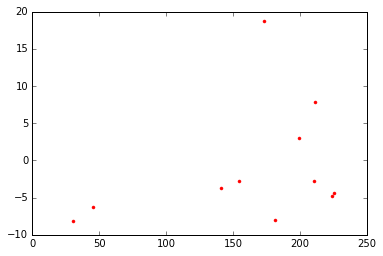

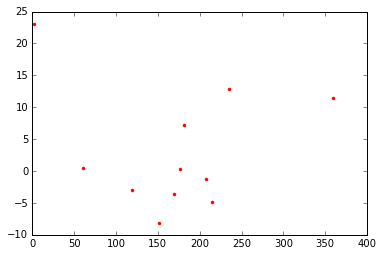

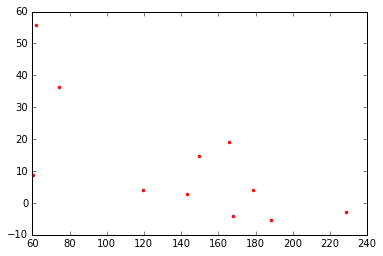

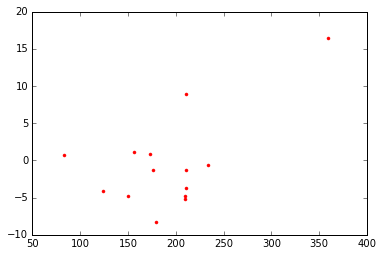

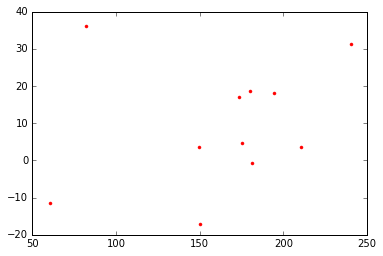

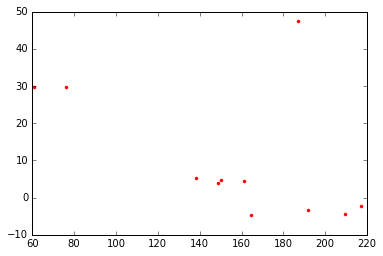

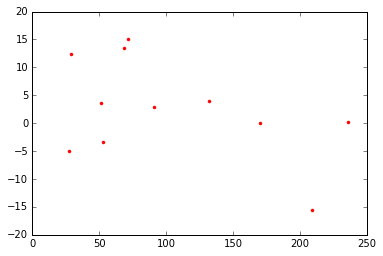

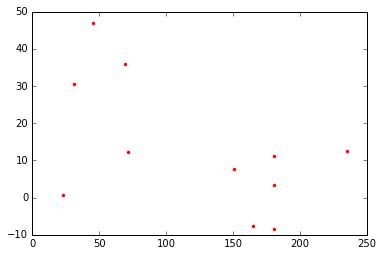

In [72]:
low_v = np.where((np.abs(v_x) < 200) * ((np.abs(v_y) < 200)))[0]
H, xedges, yedges = np.histogram2d(v_x[low_v], v_y[low_v], bins=200)
rows, cols = np.where(H > 10)
print rows, cols
rows_cols = np.array([rows, cols]).T
print interest
for ele in rows_cols:
    stars = np.where((v_x > xedges[ele[0]]) * (v_x < xedges[ele[0]+1]) 
                    * (v_y > yedges[ele[1]]) * ((v_y < yedges[ele[1]+1])))[0]
    plt.plot(l[stars], b[stars], "r.")
    plt.show()

5


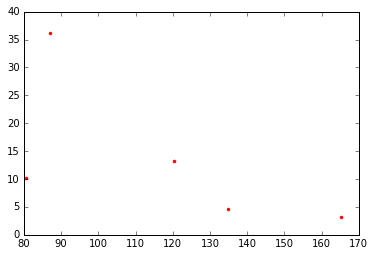

6


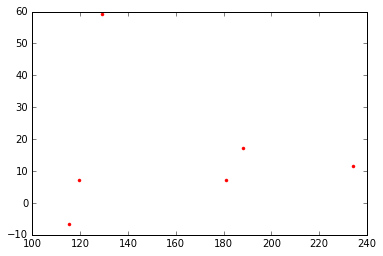

5


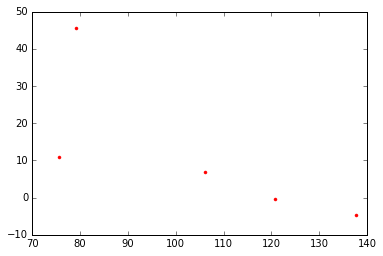

6


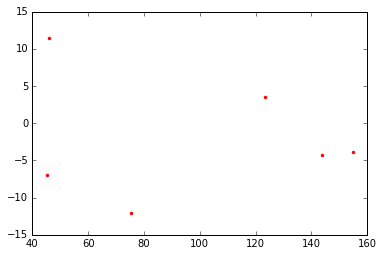

8


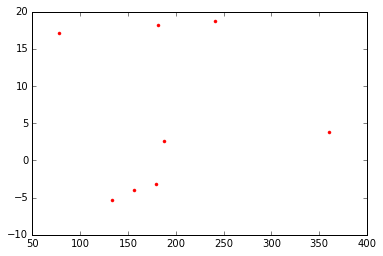

6


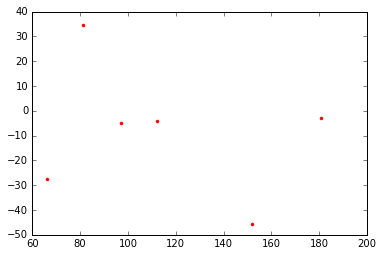

5


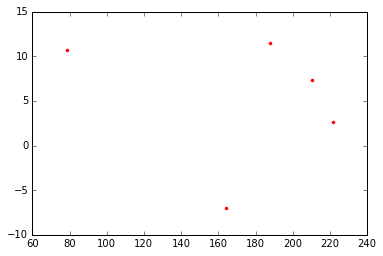

5


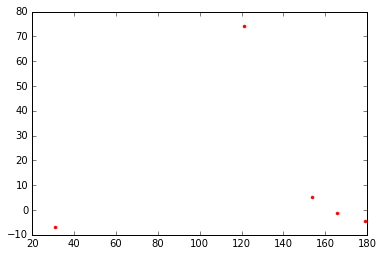

6


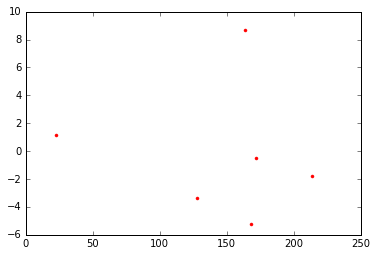

5


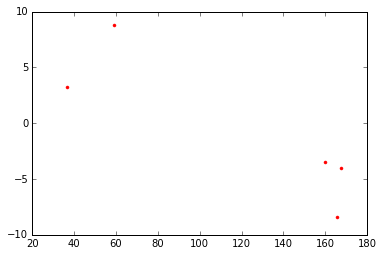

5


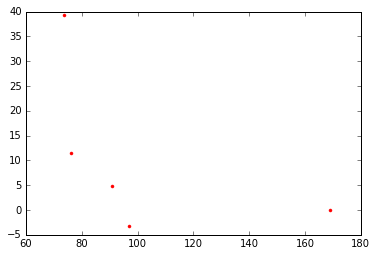

5


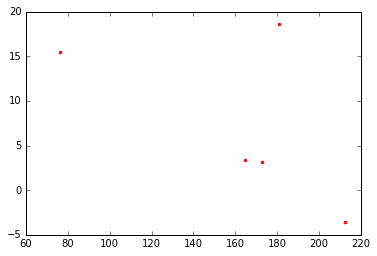

6


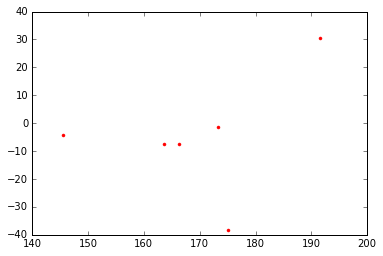

5


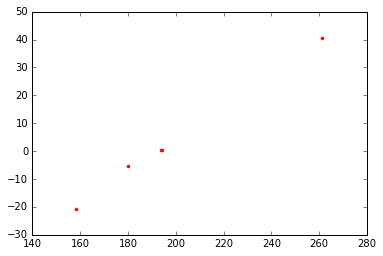

6


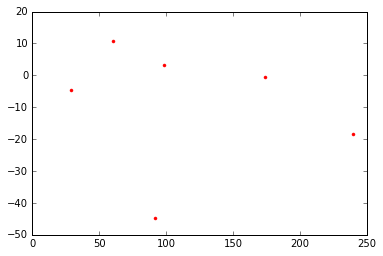

5


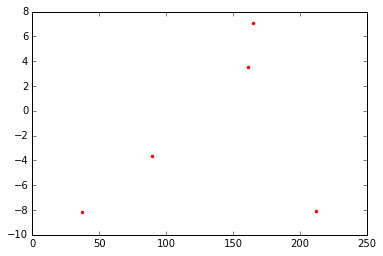

5


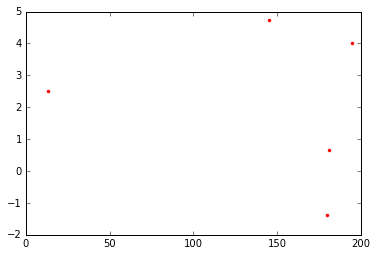

5


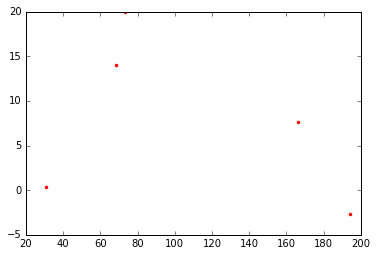

5


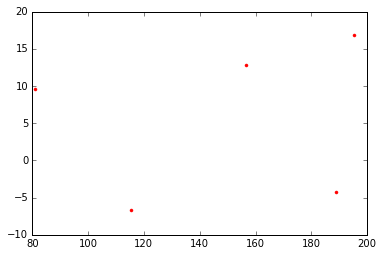

6


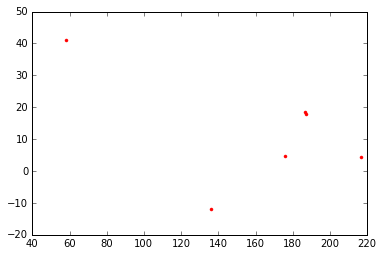

5


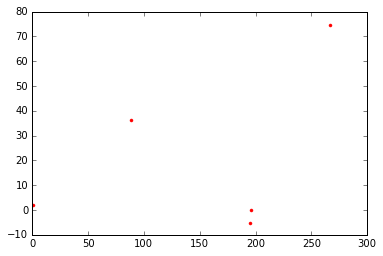

5


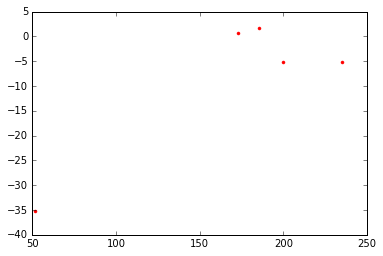

5


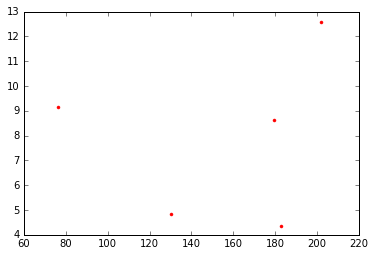

5


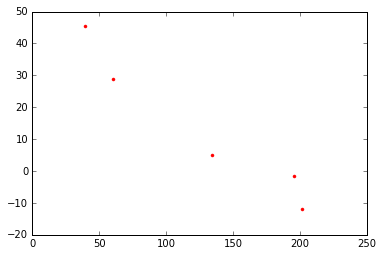

5


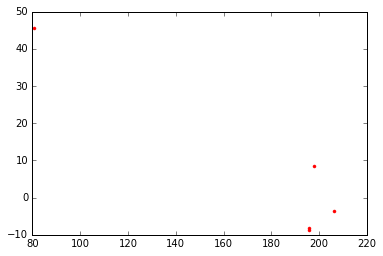

5


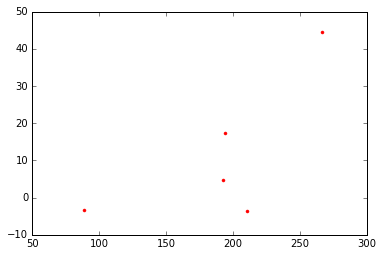

5


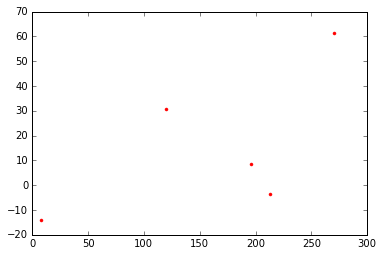

5


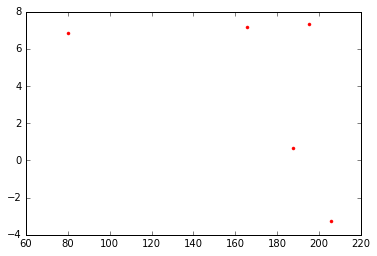

5


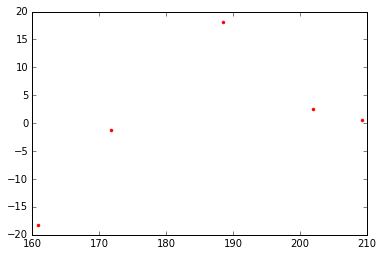

5


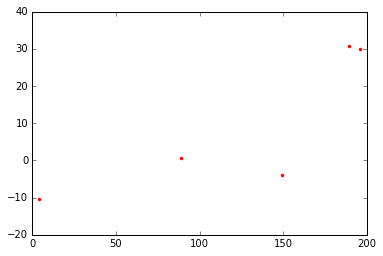

5


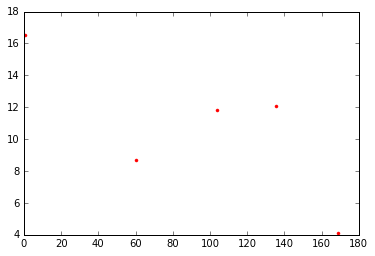

5


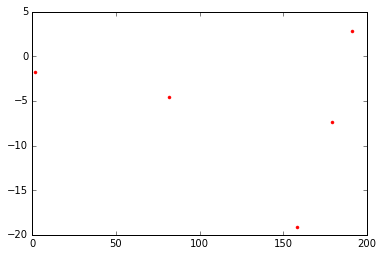

In [26]:
for n in range(labels.max()+1):
    group = C[np.where(labels == n)[0]]
    print group.size
    fig = plt.figure()
    plt.plot(l[group], b[group], "r.")
    plt.show()